**1. Using IBM Granite to Classification and Summarization Cyberbullying Data**

*   Instalasi Library

In [30]:
!pip install langchain_community
!pip install replicate
!pip install pandas

*   Konfigurasi API Key Replicate
*   Inisialisasi Model IBM Granite

In [31]:
import os
from langchain_community.llms import Replicate
from google.colab import userdata

# Ambil API token dari Google Colab Secrets
api_token = userdata.get("REPLICATE_API_KEY")
os.environ["REPLICATE_API_TOKEN"] = api_token

# Inisialisasi IBM Granite model
model = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    replicate_api_token=api_token,
)


*   Memuat dan Membersihkan Dataset CSV
*   Melihat Data Awal

In [38]:
import pandas as pd

# Upload CSV dari sidebar atau pastikan path benar
file_path = "/content/dataset_cyberbullying.csv"  # Ganti sesuai nama file kamu
# Try reading the CSV with a different encoding
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1')


# Pastikan hanya ambil kolom yang dibutuhkan
df = df[['Komentar']].dropna()

# Cek 5 baris awal
display(df.head())

,Komentar
0,"""Kaka tidur yaa, udah pagi, gaboleh capek2"""
1,"""makan nasi padang aja begini badannya"""
2,"""yang aku suka dari dia adalah selalu cukur je..."
3,"""Hai kak Isyana aku ngefans banget sama kak Is..."
4,"""Manusia apa bidadari sih herann deh cantik te..."


*   Mengambil Komentar Teratas
*   Melakukan Loop untuk Ringkasan dan Klasifikasi AI
*   Mencetak Hasil Ringkasan dan Klasifikasi per Komentar

In [33]:
# Ambil 5 komentar teratas dari dataset
top_komentar = df['Komentar'].dropna().head(5).tolist()

# List untuk menyimpan hasil
ringkasan_list = []
klasifikasi_list = []

# Loop tiap komentar
for i, komentar in enumerate(top_komentar):
    print(f"\n🔹 Komentar ke-{i+1}:\n\"{komentar}\"")

    # Prompt untuk merangkum komentar
    prompt_summary = f"""
Tugas kamu adalah merangkum komentar media sosial berikut menjadi satu kalimat pendek yang menjelaskan inti komentar dalam bahasa Indonesia.

Komentar:
"{komentar}"

Berikan hanya satu kalimat ringkasan tanpa penjelasan tambahan.
"""
    summary = model.invoke(prompt_summary).strip()
    ringkasan_list.append(summary)
    print(f"\n📄 Ringkasan:\n{summary}")

    # Prompt untuk klasifikasi komentar (Bullying / Bukan Bullying)
    prompt_klasifikasi = f"""
Evaluasilah komentar media sosial berikut berdasarkan kriteria berikut:

Komentar dikategorikan sebagai **Bullying** jika:
- Mengandung hinaan, cercaan, atau ejekan langsung atau tersirat
- Menyerang fisik, penampilan, nama, keluarga, atau kepribadian seseorang
- Mengganggu privasi, martabat, atau kenyamanan orang lain
- Bisa menyebabkan dampak emosional atau psikologis

Komentar dikategorikan sebagai **Bukan Bullying** jika:
- Netral, tidak menyerang personal
- Opini umum tanpa unsur hinaan/pelecehan

Komentar:
"{komentar}"

Berikan hasil dengan format seperti berikut:

🧾 Hasil Evaluasi:
<Analisis singkat dalam 1-2 kalimat>
Kategori: <Bullying / Bukan Bullying>
"""
    klasifikasi = model.invoke(prompt_klasifikasi).strip()
    klasifikasi_list.append(klasifikasi)
    print(f"\n{klasifikasi}")



🔹 Komentar ke-1:
""Kaka tidur yaa, udah pagi, gaboleh capek2""

📄 Ringkasan:
Komentar mengingat mendongkrak keseharian sehari yang baru, memuji tetap tidur meskipun sudah pagi.

🧾 Hasil Evaluasi:
Komentar tersebut tidak mengandung unsur hinaan, cercaan, atau ejekan, dan juga tidak menyerang fisik, penampilan, nama, keluarga, atau kepribadian seseorang. Ini hanya pesan yang netral dan tidak menyisihkan siapa pun.

Kategori: Bukan Bullying

🔹 Komentar ke-2:
""makan nasi padang aja begini badannya""

📄 Ringkasan:
Komentar mengingatkan bahwa makan nasi Padang bersifat sehat dan tetap mampu membuat badan tetap cantik.

🧾 Hasil Evaluasi:
Komentar tersebut dikategorikan sebagai **Bullying** karena menyerang penampilan seseorang secara langsung dengan mengaitkannya dengan keadaan badannya.
Kategori: Bullying

**Catatan:** Komentar ini dapat dipahami sebagai serangan langsung terhadap kepribadian dan penampilan seseorang, yang secara langkah kemudian dibandingkan dengan keadaan badannya. Ini m

*   Membuat DataFrame Hasil


In [37]:
df_hasil = pd.DataFrame({
    "Komentar": top_komentar,
    "Ringkasan": ringkasan_list,
    "Evaluasi": klasifikasi_list
})


df_hasil


,Komentar,Ringkasan,Evaluasi
0,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",Komentar mengingat mendongkrak keseharian seha...,🧾 Hasil Evaluasi:\nKomentar tersebut tidak men...
1,"""makan nasi padang aja begini badannya""",Komentar mengingatkan bahwa makan nasi Padang ...,🧾 Hasil Evaluasi:\nKomentar tersebut dikategor...
2,"""yang aku suka dari dia adalah selalu cukur je...",Komentar mengingatkan tentang sikap yang terci...,🧾 Hasil Evaluasi:\nKomentar tersebut dikategor...
3,"""Hai kak Isyana aku ngefans banget sama kak Is...","Penulis sangat menyukai lagu Isyana, yang mere...",🧾 Hasil Evaluasi:\nKomentar tersebut tidak men...
4,"""Manusia apa bidadari sih herann deh cantik te...",Komentar mengingatkan terhadap perbandingan an...,🧾 Hasil Evaluasi:\nKomentar tersebut dikategor...


*   Evaluasi Performa Model AI
*   Menghitung Akurasi
*   Menampilkan Confusion Matrix dan Classification Report

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Ambil 5 label asli pertama dan ubah ke format seragam
kategori_asli = df['Kategori'].head(5).tolist()
kategori_asli_normalized = ['Bullying' if k.lower() == 'bullying' else 'Bukan Bullying' for k in kategori_asli]

# Normalisasi label AI agar aman (misalnya AI kadang beri huruf kecil)
klasifikasi_list_normalized = ['Bullying' if k.lower() == 'bullying' else 'Bukan Bullying' for k in klasifikasi_list]

# Evaluasi akurasi
akurasi = accuracy_score(kategori_asli_normalized, klasifikasi_list_normalized)
print(f"\n✅ Akurasi AI: {akurasi * 100:.2f}%")

# Confusion Matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(kategori_asli_normalized, klasifikasi_list_normalized, labels=["Bullying", "Bukan Bullying"]),
    index=["Asli: Bullying", "Asli: Bukan Bullying"],
    columns=["Pred: Bullying", "Pred: Bukan Bullying"]
)
print("\n📊 Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(kategori_asli_normalized, klasifikasi_list_normalized, target_names=["Bullying", "Bukan Bullying"]))



✅ Akurasi AI: 80.00%

📊 Confusion Matrix:
                      Pred: Bullying  Pred: Bukan Bullying
Asli: Bullying                     0                     1
Asli: Bukan Bullying               0                     4

📋 Classification Report:
                precision    recall  f1-score   support

      Bullying       0.80      1.00      0.89         4
Bukan Bullying       0.00      0.00      0.00         1

      accuracy                           0.80         5
     macro avg       0.40      0.50      0.44         5
  weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


*   Menguji Klasifikasi pada Komentar Baru
*   Mencetak Hasil Uji Coba

In [36]:
komentar = "Kamu jelek banget kayak kuali bolong"

prompt_klasifikasi = f"""
Analisis komentar media sosial berikut dan lakukan dua hal:
1. Berikan penjelasan singkat (1 kalimat) mengapa komentar ini tergolong "Bullying" atau "Bukan Bullying" dalam bahasa indonesia.
2. Tulis kategorinya secara tegas di akhir dengan format:
Penjelasan: ...
Kategori: Bullying atau Bukan Bullying

Komentar:
"{komentar}"
"""


result = model.invoke(prompt_klasifikasi).strip()

print(f"Komentar: {komentar}\n{result}")


Komentar: Kamu jelek banget kayak kuali bolong
Penjelasan: Komentar ini tergolong "Bullying" karena itu mengandung kritikan yang sifatnya agresif, terulung, dan bertujuan untuk menghina atau menghina orang lain, yang merupakan karakteristik bullying.

Kategori: Bullying


**2. Insight dan Visualization Data**

Kode ini bertujuan untuk mendapatkan insight awal dari dataset.

In [41]:
# Import library pandas
import pandas as pd

# Asumsi df sudah dimuat dari langkah sebelumnya

# Menampilkan jumlah total komentar
total_komentar = df.shape[0]
print(f"Jumlah total komentar: {total_komentar}\n")

# Menampilkan distribusi komentar berdasarkan kategori
if 'Kategori' in df.columns:
    print("Distribusi komentar berdasarkan kategori:")
    display(df['Kategori'].value_counts())
else:
    print("Kolom 'Kategori' tidak ditemukan di DataFrame.")

# Menampilkan rata-rata panjang komentar per kategori (jika kolom Kategori ada)
if 'Kategori' in df.columns:
    df['Panjang_Komentar'] = df['Komentar'].apply(len)
    print("\nRata-rata panjang komentar per kategori:")
    display(df.groupby('Kategori')['Panjang_Komentar'].mean())

Jumlah total komentar: 650

Distribusi komentar berdasarkan kategori:


,count
Kategori,
Non-bullying,325
Bullying,325



Rata-rata panjang komentar per kategori:


,Panjang_Komentar
Kategori,
Bullying,56.547692
Non-bullying,69.695385


Visualisasi distribusi komentar berdasarkan kategori.

/tmp/ipython-input-733604499.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Kategori', palette='viridis')


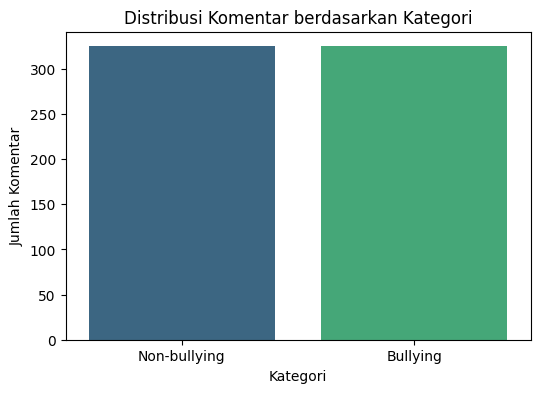

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi komentar berdasarkan kategori
if 'Kategori' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='Kategori', palette='viridis')
    plt.title('Distribusi Komentar berdasarkan Kategori')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Komentar')
    plt.show()
else:
    print("Kolom 'Kategori' tidak ditemukan di DataFrame untuk visualisasi.")

Visualisasi rata-rata panjang komentar per kategori.

/tmp/ipython-input-4069672922.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Kategori', y='Panjang_Komentar', palette='viridis')


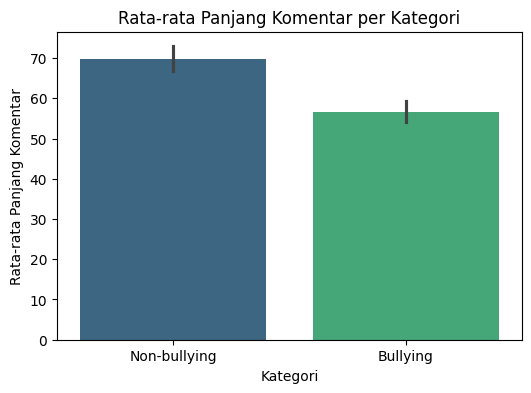

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi rata-rata panjang komentar per kategori
if 'Kategori' in df.columns and 'Panjang_Komentar' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x='Kategori', y='Panjang_Komentar', palette='viridis')
    plt.title('Rata-rata Panjang Komentar per Kategori')
    plt.xlabel('Kategori')
    plt.ylabel('Rata-rata Panjang Komentar')
    plt.show()
elif 'Kategori' not in df.columns:
    print("Kolom 'Kategori' tidak ditemukan di DataFrame untuk visualisasi rata-rata panjang komentar.")
elif 'Panjang_Komentar' not in df.columns:
     print("Kolom 'Panjang_Komentar' tidak ditemukan di DataFrame. Pastikan Anda sudah menghitung panjang komentar.")